In [8]:
import math
import random

def lcm(a,b):
    return int(abs(a * b) / math.gcd(a,b) if a and b else 0)

def lcml(lst):
    '''lcm for multiple factors'''
    if len(lst) < 2:
        return 1
    clcm = lst.pop()
    while len(lst)>0:
        clcm = lcm(lst.pop(), clcm)
    return clcm

def gcdl(lst):
    '''gcd for multiple factors'''
    if len(lst) < 2:
        return 1
    cgcd = lst.pop()
    while len(lst)>0:
        cgcd = math.gcd(lst.pop(), cgcd)
    return cgcd

if __name__=="__main__":
    a = random.randrange(10,100)
    b = random.randrange(10,100)
    print('lcm/kgV ', a, ',', b, '=', lcm(a, b))
    
    a = random.randrange(5,40)
    b = random.randrange(5,40)
    c = random.randrange(5,40)
    print('lcm/kgV: ', a,b,c,lcml([a,b,c]))
    
    a = random.randrange(10,100)
    b = random.randrange(10,100)
    print('gcd/ggT ', a, ',', b, '=', math.gcd(a, b))
    
    a = random.randrange(5,40)
    b = random.randrange(5,40)
    c = random.randrange(5,40)
    print('gcd/ggT: ', a,b,c,gcdl([a,b,c]))
    
    a = random.randrange(40,800) / 40
    b = random.randrange(40,800) / 40
    print(a, ' : ', b, '=', a/b)
    a = random.randrange(40,500) / 40
    b = random.randrange(40,500) / 40
    print(a, ' * ', b, '=', a*b)
    
    #print('lcm/kgV: ', a,b,c,lcml([52,62]))
    #print('lcm/kgV: ', a,b,c,lcml([29,8,13]))

lcm/kgV  87 , 89 = 7743
lcm/kgV:  14 38 7 266
gcd/ggT  37 , 38 = 1
gcd/ggT:  17 10 25 1
3.525  :  7.25 = 0.4862068965517241
6.875  *  4.925 = 33.859375


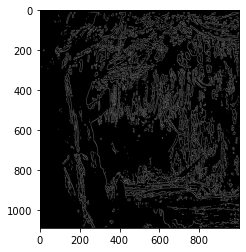

In [19]:
# canny edge detector
import numpy as np
from scipy.ndimage.filters import convolve, gaussian_filter
#from scipy.misc import imread, imshow
#from matplotlib.pyplot import imread, imshow
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
 
def CannyEdgeDetector(im, blur = 1, highThreshold = 91, lowThreshold = 31):
    im = np.array(im, dtype=float) #Convert to float to prevent clipping values
    
    # Gaussian blur to reduce noise
    im2 = gaussian_filter(im, blur)

    # Use sobel filters to get horizontal and vertical gradients
    im3h = convolve(im2,[[-1,0,1],[-2,0,2],[-1,0,1]]) 
    im3v = convolve(im2,[[1,2,1],[0,0,0],[-1,-2,-1]])

    # Get gradient and direction
    grad = np.power(np.power(im3h, 2.0) + np.power(im3v, 2.0), 0.5)
    theta = np.arctan2(im3v, im3h)
    thetaQ = (np.round(theta * (5.0 / np.pi)) + 5) % 5 #Quantize direction

    #Non-maximum suppression
    gradSup = grad.copy()
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            # Suppress pixels at the image edge
            if r == 0 or r == im.shape[0]-1 or c == 0 or c == im.shape[1] - 1:
                gradSup[r, c] = 0
                continue
            tq = thetaQ[r, c] % 4

            if tq == 0: #0 is E-W (horizontal)
                if grad[r, c] <= grad[r, c-1] or grad[r, c] <= grad[r, c+1]:
                    gradSup[r, c] = 0
            if tq == 1: #1 is NE-SW
                if grad[r, c] <= grad[r-1, c+1] or grad[r, c] <= grad[r+1, c-1]:
                    gradSup[r, c] = 0

            if tq == 2: #2 is N-S (vertical)
                if grad[r, c] <= grad[r-1, c] or grad[r, c] <= grad[r+1, c]:
                    gradSup[r, c] = 0
                    
            if tq == 3: #3 is NW-SE
                if grad[r, c] <= grad[r-1, c-1] or grad[r, c] <= grad[r+1, c+1]:
                    gradSup[r, c] = 0
            
    # Double threshold
    strongEdges = (gradSup > highThreshold)
    # Strong has value 2, weak has value 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gradSup > lowThreshold)

    # Tracing edges with hysteresis	

    # Find weak edge pixels near strong edge pixels
    finalEdges = strongEdges.copy()

    currentPixels = []
    for r in range(1, im.shape[0]-1):
        for c in range(1, im.shape[1]-1):	
            if thresholdedEdges[r, c] != 1:
                continue # Not a weak pixel

            # Get 3x3 patch	
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
            finalEdges[r, c] = 1

    # Extend strong edges based on current pixels
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        # Copy this weak pixel to final result
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
                    currentPixels = newPix

    return finalEdges

if __name__=="__main__":
    #im = Image.open('mw01.jpg') #Open image, convert to greyscale
    im = mpimg.imread('mw01.jpg')
    im_gray = rgb2gray(im)
    finalEdges = CannyEdgeDetector(im_gray)
    #mpimg.imshow(finalEdges)
    plt.imshow(finalEdges, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()

In [6]:
# align columns
from itertools import zip_longest
 
txt = """Given$a$txt$file$of$many$lines,$where$fields$within$a$line$
are$delineated$by$a$single$'dollar'$character,$write$a$program
that$aligns$each$column$of$fields$by$ensuring$that$words$in$each$
column$are$separated$by$at$least$one$space.
Further,$allow$for$each$word$in$a$column$to$be$either$left$
justified,$right$justified,$or$center$justified$within$its$column."""
 
parts = [line.rstrip("$").split("$") for line in txt.splitlines()]
widths = [max(len(word) for word in col) 
          for col in zip_longest(*parts, fillvalue='')]
 
for justify in "<_Left ^_Center >_Right".split():
    j, jtext = justify.split('_')
    print(f"{jtext} column-aligned output:\n")
    for line in parts:
        print(' '.join(f"{wrd:{j}{wdth}}" for wdth, wrd in zip(widths, line)))
    print("- " * 52)

Left column-aligned output:

Given      a          txt        file   of     many      lines,     where    fields  within  a      line
are        delineated by         a      single 'dollar'  character, write    a       program
that       aligns     each       column of     fields    by         ensuring that    words   in     each
column     are        separated  by     at     least     one        space.  
Further,   allow      for        each   word   in        a          column   to      be      either left
justified, right      justified, or     center justified within     its      column.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Center column-aligned output:

  Given        a         txt      file    of     many      lines,    where   fields  within    a    line
   are     delineated     by       a    single 'dollar'  character,  write      a    program
   that      aligns      each    column   of    fields       by    

In [22]:
# pandas import test
import pandas as pd
import os

MY_PATH = r'C:\Users\bscho\Documents\DL\lrgtxt0'
os.chdir(MY_PATH)
data = pd.read_excel (r'Janssen_Neuro_mit_Tendenzen_und_Insights_202010.xlsx')
# df = pd.read_excel (r'Path where the Excel file is stored\File name.xlsx', sheet_name='your Excel sheet name')
df = pd.DataFrame(data, columns= ['Nachname']) # as a test, choose a column
print (df)

               Nachname
0                  Dürr
1               Poustka
2                Behrus
3                Kleber
4            Innerhofer
...                 ...
1937  Ücker-Geischläger
1938             Huemer
1939             Huemer
1940      Hüttenbrenner
1941  Hünlein-Hillinger

[1942 rows x 1 columns]


In [9]:
# rakkimaths
import random

def bcalc(nlim=50):
    f0 = random.randint(10,nlim)
    f1 = random.randint(0,f0-1)
    s0 = random.choice([0,1]) # 0=+, 1=-
    if s0==0:
        r0 = f0 + f1
    else:
        r0 = f0 - f1
    return [f0, s0, f1, r0]

def pclc(ctpl):
    if ctpl[1] == 0:
        print(ctpl[0],'+',ctpl[2],'=',ctpl[3])
    else:
        print(ctpl[0],'-',ctpl[2],'=',ctpl[3])

if __name__=="__main__":
    for i in range(5):
        clc0 = bcalc()
        pclc(clc0)
        clc0[random.choice([0,2,3])] = 0
        pclc(clc0)
        print('**************')

47 - 4 = 43
0 - 4 = 43
**************
45 + 16 = 61
45 + 0 = 61
**************
25 - 0 = 25
25 - 0 = 25
**************
25 + 17 = 42
0 + 17 = 42
**************
47 - 39 = 8
47 - 0 = 8
**************


In [2]:
# simplifications
def qdrexp(a):
    if a[0]=='(':
        ac = a + '*' + a
    elif a.isnumeric():
        ac = str(int(a)**2)
    else:
        ac = str(int(a[0:-1])**2) + a[-1:] + '*' + a[-1:] 
    return ac

def mulexp(a,b):
    if a[0]=='(' or b[0]=='(':
        ac = a + '*' + b
    elif a.isnumeric() and b.isnumeric():
        ac = str(int(a)*int(b))
    elif a.isnumeric() and not b.isnumeric():
        ac = str(int(a)*int(b[0:-1])) + '*' + b[-1:]
    elif not a.isnumeric() and b.isnumeric():
        ac = str(int(a[0:-1])*int(b)) + '*' + a[-1:]
    else:
        ac = str(int(a[0:-1])*int(b[0:-1])) + a[-1:] + '*' + b[-1:] 
    return ac   

def binom(a,b):
    return '(' + qdrexp(a) + ' - ' + qdrexp(b) + ')'

def quadr(a,b):
    return '(' + qdrexp(a) + ' + 2*' + mulexp(a,b) + ' + ' + qdrexp(b) + ')'

if __name__=="__main__":
    print(binom('12x','3'))
    print(binom('(2x-3)','3'))
    print(quadr('12x','3'))

(144x*x - 9)
((2x-3)*(2x-3) - 9)
(144x*x + 2*36*x + 9)


In [12]:
d = {"Month":[1,2,3,4,5,6],"Rain":[30,40,50,20,30,70]}
#new_d = {"Month":[2,4,6],"Rain":[40,20,70]}
mths_to_choose = [2,4,6]

for keyval in d.items():
    new_d[keyval[0]] = []
    for i in mths_to_choose: # if filter_string in key: # do something
        new_d[keyval[0]].append(keyval[1][i-1])
    # else# do nothing, continue  
print(new_d)

new_d = {ditms[0]: [ditms[1][i-1] for i in mths_to_choose] for ditms in d.items()}
print(new_d)

{'Month': [2, 4, 6], 'Rain': [40, 20, 70]}
{'Month': [2, 4, 6], 'Rain': [40, 20, 70]}


In [13]:
# Chinese remainder
from functools import reduce

def chinese_remainder(n, a):
    sum = 0
    prod = reduce(lambda a, b: a*b, n)
    for n_i, a_i in zip(n, a):
        p = prod // n_i
        sum += a_i * mul_inv(p, n_i) * p
    return sum % prod

def mul_inv(a, b):
    b0 = b
    x0, x1 = 0, 1
    if b == 1: return 1
    while a > 1:
        q = a // b
        a, b = b, a%b
        x0, x1 = x1 - q * x0, x0
    if x1 < 0: x1 += b0
    return x1

if __name__ == '__main__':
    n = [3, 5, 7]
    a = [2, 3, 2]
    print(chinese_remainder(n, a))

23


In [1]:
# splitting strings
numbers = '0123456789'
operators = '^/*+-%dr='

inp = '3096+41*12-dd+31^2rrr'

outp = []
cn = '' # current number 
for i in range(len(inp)):
    if inp[i] in numbers: # check string element-wise
        cn += inp[i] # compile current number
    elif inp[i] in operators:
        if len(cn) > 0: # we have an integer in store (as string)
            outp.append(int(cn)) # which we append as int
            cn = '' # and clear for the next number
        outp.append(inp[i])
    else:
        pass # todo: non-treatable tokens

print(outp)
#outp = [3096,+,41,*,12,-,d,d,+,31,2,r,r,r]

[3096, '+', 41, '*', 12, '-', 'd', 'd', '+', 31, '^', 2, 'r', 'r', 'r']


In [59]:
inp = [[('A Sam', 'count1'), 1], [('A Sam', 'count2'), 2], [('T King', 'count1'), 2], [('C Baskin', 'count2'), 1]]
outp = {"A Sam": [1,2], "T King": [2,0], "C Baskin": [0,1]} # "name": [position_ct1, position_ct2]

ctmp = lambda x: 'count' + x
ctimp = lambda x: int(x.replace('count',''))
ctimpl = lambda x: [idx if idx == int(x.replace('count',''))-1 else 0 for idx in range(2)]

#print([ctimp(el[0][1]) for el in inp])

print([ctimpl(el[0][1]) for el in inp])

ctl = [1, 2]
print({dcel: [ctl[ctimp(el[0][1])-1] for el in inp if el[0][0] == dcel] for dcel in set([inpel[0][0] for inpel in inp])})

[[0, 0], [0, 1], [0, 0], [0, 1]]
{'A Sam': [1, 2], 'C Baskin': [2], 'T King': [1]}


In [119]:
import math

PI = 3.14159265358979323846

def fatorial(n):
    fatorial = 1
    for i in range(1,n+1,1):
        fatorial = fatorial * i
    return fatorial 

def seno(theta): 
    n = 1
    k = 3
    eps = 10**-10
    theta = (theta*PI)/180
    thetas = theta # <- added this
    x = -theta*theta*theta
    y = 6
    #while x/y > eps or x/y < -eps:
    while k < 14:
        thetas = thetas + (x/y) # sum thetas
        n = n + 1
        k = k + 2
        #x = ((-1)**n) * ((theta)**k)
        x = ((-1)**(n%2)) * ((theta)**k) # but use the original value for the series
        #y = fatorial(k)
        y *= k * (k-1)
    return thetas # return the sum

if __name__ == '__main__':
    print(seno(80), math.sin(8*PI/18))

0.984807753125684 0.984807753012208
